In [90]:
import networkx as nx
import EoN
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import defaultdict
import numpy as np
import random
import pandas as pd
import time
from tqdm import tqdm
from itertools import combinations
import pandas as pd

import matplotlib as mpl
import datetime
import scipy.stats
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)

import seaborn as sns
mpl.rcParams.update(mpl.rcParamsDefault)
inline_rc = dict(mpl.rcParams)

C:\Users\caoq\Anaconda3\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# functions

In [2]:
## function for update the inforamation of each node
def update_time(reulst, G, N, upper_bound = 10000):
    for i in range(N):
        if G._node[i]['status'] == "S":
            for j in range(1, len(reulst.node_history(i)[0])):
                if reulst.node_history(i)[0][j] <= upper_bound:
                    G._node[i].update({reulst.node_history(i)[1][j]: 
                                       reulst.node_history(i)[0][j]})
        elif G._node[i]['status'] == "E":
            for j in range(1, len(reulst.node_history(i)[0])):
                if reulst.node_history(i)[0][j] <= upper_bound:
                    G._node[i].update({reulst.node_history(i)[1][j]: 
                                       reulst.node_history(i)[0][j]})
        elif G._node[i]['status'] == "I":
            for j in range(1, len(reulst.node_history(i)[0])):
                if reulst.node_history(i)[0][j] <= upper_bound:
                    G._node[i].update({reulst.node_history(i)[1][j]: 
                                       reulst.node_history(i)[0][j]})
                                   
def update_status(G, N):
    for i in range(N):
        if G._node[i]['R']> -0.1:
            G._node[i].update({'status': "R"})
        elif G._node[i]['I']> - 0.1:
            G._node[i].update({'status': "I"})
        elif G._node[i]['E'] > -0.1:
             G._node[i].update({'status': "E"})
            
def update_from(result, G, upper_bound = 10000):
    for i in range(len(result.transmissions())):
        j = result.transmissions()[i][2]
        if G._node[j]['From'] == -1:
            if result.transmissions()[i][0]<= upper_bound:
                G._node[j].update({'From': result.transmissions()[i][1]})

In [3]:
## function to analyze the list
def mean_var_std(list_aim):
    return(round(np.mean(list_aim),3),
           round(np.var(list_aim),3),
           round(np.std(list_aim),3))


In [4]:
 def N_average_move(input_list, average_num):
    cumsum = [0]
    if average_num == 3:
        moving_aves = [sum(input_list[:2])/2]
    if average_num == 5:
        moving_aves = [sum(input_list[:3])/3]
        moving_aves.append(sum(input_list[:4])/4)
    if average_num == 7:
        moving_aves = [sum(input_list[:4])/4]
        moving_aves.append(sum(input_list[:5])/5)
        moving_aves.append(sum(input_list[:6])/6)
    if average_num == 9:
        moving_aves = [sum(input_list[:5])/5]
        moving_aves.append(sum(input_list[:6])/6)
        moving_aves.append(sum(input_list[:7])/7)
        moving_aves.append(sum(input_list[:8])/8)
    for i, x in enumerate(input_list, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=average_num:
            moving_ave = (cumsum[i] - cumsum[i-average_num])/average_num
            #can do stuff with moving_ave here
            moving_aves.append(moving_ave)
    if average_num == 3:
        moving_aves.append(sum(input_list[-2:])/2)
    elif average_num == 5:
        moving_aves.append(sum(input_list[-4:])/4)
        moving_aves.append(sum(input_list[-3:])/3)
    elif average_num == 7:
        moving_aves.append(sum(input_list[-6:])/6)
        moving_aves.append(sum(input_list[-5:])/5)
        moving_aves.append(sum(input_list[-4:])/4)
    else:
        moving_aves.append(sum(input_list[-8:])/8)
        moving_aves.append(sum(input_list[-7:])/7)
        moving_aves.append(sum(input_list[-6:])/6)
        moving_aves.append(sum(input_list[-5:])/5)
    
    return(moving_aves)

In [5]:
## plot the figure
def plot_mean_uppper_lower (fgure_for_plot, t_list_stand, S_list_stand, I_list_stand, finished_time, social_apply_time):
    
    S_mean = [np.mean(S_list_stand[i][1:]) for i in range(len(S_list_stand))]
    S_lowerbound  = [np.quantile(S_list_stand[i][1:], 0.05) for i in range(len(S_list_stand))]
    S_upperbound  = [np.quantile(S_list_stand[i][1:], 0.95) for i in range(len(S_list_stand))]
    I_mean = [np.mean(I_list_stand[i][1:]) for i in range(len(I_list_stand))]

    fi_in =t_list_stand.index(min(t_list_stand,key=lambda x:abs(x-finished_time)))

    fgure_for_plot.plot(t_list_stand[:fi_in], S_mean[:fi_in], color = 'C0')
    fgure_for_plot.fill_between(t_list_stand[:fi_in], S_lowerbound[:fi_in],S_upperbound[:fi_in], facecolor = 'C0', alpha=0.5,label='90% CI Total Confimred Cases' )
    fgure_for_plot.scatter(t_list_stand[fi_in],  S_mean[fi_in], color ='C0', label = 'Total Confimred Cases \n {} nodes (Mean)'.format(round( S_mean[fi_in],2)))
    fgure_for_plot.axvline(x= np.median(social_apply_time), color= 'black', linestyle = '--', label = 'Social Distancing Starts at \n  {} days (Mean)'.format(round(social_apply_time,2)))


In [6]:
def G_for_country(number_node, num_neigbor, p_newman_po, family_size):
    neigbor = num_neigbor
    p_newman = p_newman_po
    print("generating graph G with {} nodes {} neigbor and {} newconnect".
          format(number_node, neigbor, p_newman))

    G_tem = nx.generators.random_graphs.watts_strogatz_graph(number_node, num_neigbor, p_newman_po)

    for i in range(number_node):
        G_tem._node[i].update({'name':i})
        G_tem._node[i].update({'status':'S'})
        G_tem._node[i].update({'From': -1})
        G_tem._node[i].update({'S': 0})
        G_tem._node[i].update({'E': -1})
        G_tem._node[i].update({'I': -1})
        G_tem._node[i].update({'R': -1})
    
    country_stable_edges_list = []
    country_long_dis_edges_list = []
    for i in G_tem.edges:
        tem_index = int(i[0]/family_size)
        if i[1] in  range(tem_index*family_size,tem_index*family_size+family_size):
            country_stable_edges_list.append(i)
        else:
            country_long_dis_edges_list.append(i)

    print("num orginal edges: ", len(G_tem.edges))
    print("num baxic edges: ", len(country_stable_edges_list))
    print("num long dis edges: ", len(country_long_dis_edges_list))
    
    return(G_tem,country_stable_edges_list, country_long_dis_edges_list )

In [7]:
# simulation with the end of the second stage
def SEIR_only_social_distancing(G,infrate, infected_rate, recoverey_rate,try_end_stage_one, 
                                stage_one_threshold, G_remove_list, max_time_simulation,quaran='F'):
    # the whole recored
    combine_t = []
    combine_I = []
    combine_E = []
    combine_S = []
    combine_R = []
    return_statuses = ('S', 'E', 'I', 'R')
    
    # build the subgraph
    H_pre = nx.DiGraph()
    H_pre.add_node('S')
    H_pre.add_edge('E', 'I', rate = infected_rate,)
    H_pre.add_edge('I', 'R', rate = recoverey_rate)
    J_pre = nx.DiGraph()
    J_pre.add_edge(('I', 'S'), ('I', 'E'), rate = infrate)
    J_pre.add_edge(('E', 'S'), ('E', 'E'), rate = infrate)
    
    
    # set inital input variables
    start_time = 0
    end_time = try_end_stage_one 
    inital_status = nx.get_node_attributes(G, 'status')
    num_node = len(G._node)
    
    final_cuc = 0
    while final_cuc < round(stage_one_threshold*num_node)+1:
        # run simulation in each time_interval before the first time threshold coming
        sim_data =  EoN.Gillespie_simple_contagion(G, H_pre, J_pre, inital_status, return_statuses,
                                                   tmin = start_time, tmax =end_time,return_full_data=True)
        tem_cuc_list = [sim_data.I().tolist()[k]+sim_data.R().tolist()[k] for k in range(len(sim_data.I()))]
        final_cuc = tem_cuc_list[-1]
    
    close_stage_1_time_index = tem_cuc_list.index(round(stage_one_threshold*num_node))+1
    close_stage_1_time = sim_data.t()[close_stage_1_time_index-1]
    
    ## updata information of each node
    update_time(sim_data, G, num_node, close_stage_1_time)
    update_status(G, num_node)
    update_from(sim_data ,G,close_stage_1_time)
    
    ## record the simiulation result
    combine_t = combine_t + sim_data.t().tolist()[:close_stage_1_time_index]
    combine_E = combine_E + sim_data.summary()[1]['E'].tolist()[:close_stage_1_time_index]
    combine_S = combine_S + sim_data.S().tolist()[:close_stage_1_time_index]
    combine_I = combine_I + sim_data.I().tolist()[:close_stage_1_time_index]
    combine_R = combine_R + sim_data.R().tolist()[:close_stage_1_time_index]
    G_1 =G.copy()
    E_case_in_sd = combine_E[-1]


    
    ## The second stage
    # Remove list from remove_list  
    for i in G_remove_list:
        G.remove_edge(*i)
    
    inital_status = nx.get_node_attributes(G, 'status')
    start_time = close_stage_1_time
    
    #if quaran == "T":
     #   J_pre.edges[(('E', 'S'), ('E', 'E'))]['rate']=0.032
      #  J_pre.edges[(('I', 'S'), ('I', 'E'))]['rate']=0.032
        
    # run the simulation of the second stage after removing edges
    sim_data =  EoN.Gillespie_simple_contagion(G, H_pre, J_pre, inital_status, return_statuses, tmin = start_time, 
                                               tmax = max_time_simulation, return_full_data = True)
    
    # updata information of each node
    update_time(sim_data, G, num_node)
    update_status(G, num_node)
    update_from(sim_data ,G)

    # record the simiulation result
    combine_t = combine_t + sim_data.t().tolist()
    combine_S = combine_S + sim_data.S().tolist()
    combine_E = combine_E + sim_data.summary()[1]['E'].tolist()
    combine_I = combine_I + sim_data.I().tolist()
    combine_R = combine_R + sim_data.R().tolist()
    
    return(combine_t,combine_S, combine_E, combine_I,combine_R,close_stage_1_time, G_1, G,sim_data, E_case_in_sd )   


In [8]:
def SEIR_social_case_multi_run(G_tem, country_stable_edges_list, country_long_dis_edges_list, threshold_social_dis,
                              policy_power, name, repeat_time, max_time_for_simulation):
    # recored each iteration and the time of new infected node
    wo_final_cumu = []
    wo_infected_peak = [] 
    wo_infected_peak_time = []
    wo_final_stop_time = []
    wo_apply_social = []
    wo_exposed_number_in_social = []

    arr_record_cumu = []
    arr_record_I = []
    arr_record_R = []

    label_plot = ['I', 'R','Cumu']
    
    ## create a same timeline for all simualtions of benchmark
    pre_t_standard = [d for d in np.arange(0, max_time_for_simulation+0.2, 0.2)]
    arr_record_cumu = []
    arr_record_I = []
    arr_record_R = []
    
    ## recored all run result in each time point
    for i in pre_t_standard:
        arr_record_cumu.append([i])
        arr_record_I.append([i])
        arr_record_R.append([i])

    # reocrd the time
    for i in range(repeat_time):
        G = G_tem.copy()
        N = len(G_tem.nodes())
        initial_infected_list = random.sample(range(N), round(N*rho_set))
        for i in initial_infected_list:
            G._node[i]['I'] = 0
            G._node[i]['status'] = 'I'
            G._node[i]['From'] = None

        prob_edges_remove =policy_power
        # random pick remove list from non-neighbor edages   
        G_country_remove_list = random.sample(country_long_dis_edges_list, 
                                              round(len(country_long_dis_edges_list)*prob_edges_remove))

        result = SEIR_only_social_distancing(G,beta, tau ,gamma,40,threshold_social_dis, 
                                             G_country_remove_list, max_time_for_simulation,quaran="T")

        pre_t = result[0]
        pre_S = result[1]
        pre_I = result[3]
        pre_R = result[4]
        result_stage = result[5]
        
        infected_peak = max(pre_I)
        infected_peak_time = pre_t[pre_I.index(infected_peak)]
        final_stop_time  = pre_t[-1]

        # combine all data following the time line
        index_time_line = [pre_t.index(min(pre_t, key=lambda x:abs(x-i))) for i in pre_t_standard] 
        pre_I_standard = [pre_I[i] for i in index_time_line]
        pre_R_standard = [pre_R[i] for i in index_time_line]

        for i in range(len(pre_t_standard)):
            arr_record_cumu[i].append(pre_I_standard[i]+pre_R_standard[i])
            arr_record_I[i].append(pre_I_standard[i])
            arr_record_R[i].append(pre_R_standard[i])

        wo_final_cumu.append(pre_I[-1]+pre_R[-1] ) 
        wo_infected_peak.append(infected_peak)
        wo_infected_peak_time.append(infected_peak_time) 
        wo_final_stop_time.append(final_stop_time)
        wo_apply_social.append(result_stage)
        wo_exposed_number_in_social.append(result[9])


#     fig = plt.figure(figsize = (6,4))
#     ax = fig.add_subplot(111)
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     plot_mean_uppper_lower (ax, pre_t_standard, arr_record_cumu, arr_record_I, 
#                             max_time_for_simulation,np.mean(wo_apply_social))

  
#     ax.set_xlabel("Time",fontsize=14)
#     ax.set_ylabel("Cases",fontsize=14)
#     ax.set_title("{}: apply {} policy power when {}% cumulative cases".format(name,round(policy_power*100), round(threshold_social_dis*100,2)))
#     #plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
#     plt.legend(loc='lower right',fontsize = 11)
#     plt.tight_layout()
#     plt.show()
    
    print("The cumulative case: ", mean_var_std(wo_final_cumu))
#     print("The infected peak: ", mean_var_std(wo_infected_peak))
#     print("The time of infected peak:", mean_var_std(wo_infected_peak_time))
#     print("The time of policy application:", mean_var_std(wo_apply_social))
#     print("The exposed case when policy application:", mean_var_std(wo_exposed_number_in_social))
        
    return(pre_t_standard, arr_record_cumu, arr_record_I,wo_apply_social,wo_exposed_number_in_social)


# Parameters setting

In [9]:
## number of nodes
N =10000 

# initial infected fraction, 1 agent
rho_set = 0.0001
beta = 0.019

#transmission rate
tau = 1/7
# the expected connecting time with neighbor before infected is 1/tau  
# the variance is 1/(tau*tau)

#recovery rate
gamma = 1/14
# the expected recovered time after infected is 1/gamma 
# the varance is 1/(gamam*gamma)

# Contact-based Networking Building 

In [10]:
## For each country, the contact-based network is constructed by the number of the mean reported contacts and the average household size

In [13]:
## Austria
# preditcte 13.2 mean reported contacts and 2.27 average household size
G_Aus, Aus_stable_edges_list, Aus_long_dis_edges_list = G_for_country(N, 14,0.35,3)
    
G_play = G_Aus.copy()
for i in Aus_long_dis_edges_list:
    G_play.remove_edge(*i)
G_subgraph = [i for i in nx.connected_components(G_play)]
G_subgraph_node_list  = [len(i) for i in G_subgraph]
print("The distribution of household size")
print(mean_var_std(G_subgraph_node_list))

generating graph G with 10000 nodes 14 neigbor and 0.35 newconnect
num orginal edges:  70000
num baxic edges:  6497
num long dis edges:  63503
The distribution of household size
(2.274, 0.749, 0.865)


In [14]:
#Hungary
# preditcte 12.56 mean reported contacts and 2.60 average household size
G_Hun, Hun_stable_edges_list, Hun_long_dis_edges_list = G_for_country(N, 12,0.23,3)
    
G_play = G_Hun.copy()
for i in Hun_long_dis_edges_list:
    G_play.remove_edge(*i)
G_subgraph = [i for i in nx.connected_components(G_play)]
G_subgraph_node_list  = [len(i) for i in G_subgraph]
print("The distribution of household size")
print(mean_var_std(G_subgraph_node_list))

generating graph G with 10000 nodes 12 neigbor and 0.23 newconnect
num orginal edges:  60000
num baxic edges:  7711
num long dis edges:  52289
The distribution of household size
(2.607, 0.52, 0.721)


In [16]:
# poland
# 14.40 mean reported contacts and 2.81 average household size
G_Poland, Poland_stable_edges_list, Poland_long_dis_edges_list = G_for_country(N, 14,0.12,3)
mean_var_std([G_Poland.degree(i) for i in range(N)])
G_play = G_Poland.copy()
for i in Poland_long_dis_edges_list:
    G_play.remove_edge(*i)
G_subgraph = [i for i in nx.connected_components(G_play)]
G_subgraph_node_list  = [len(i) for i in G_subgraph]
print("The distribution of household size")
print(mean_var_std(G_subgraph_node_list))

generating graph G with 10000 nodes 14 neigbor and 0.12 newconnect
num orginal edges:  70000
num baxic edges:  8787
num long dis edges:  61213
The distribution of household size
(2.879, 0.19, 0.436)


In [17]:
#Slovenia
# preditcte 12.40 mean reported contacts and 2.47 average household size
G_Slo, Slo_stable_edges_list, Slo_long_dis_edges_list = G_for_country(N, 12,0.27,3)
    
G_play = G_Slo.copy()
for i in Slo_long_dis_edges_list:
    G_play.remove_edge(*i)
G_subgraph = [i for i in nx.connected_components(G_play)]
G_subgraph_node_list  = [len(i) for i in G_subgraph]
print("The distribution of household size")
print(mean_var_std(G_subgraph_node_list))

generating graph G with 10000 nodes 12 neigbor and 0.27 newconnect
num orginal edges:  60000
num baxic edges:  7257
num long dis edges:  52743
The distribution of household size
(2.48, 0.637, 0.798)


In [18]:
#Slovakia
# preditcte 13.8 mean reported contacts and 2.80average household size
G_Slovakia, Slovakia_stable_edges_list, Slovakia_long_dis_edges_list = G_for_country(N, 14,0.15,3)
    
G_play = G_Slovakia.copy()
for i in Slovakia_long_dis_edges_list:
    G_play.remove_edge(*i)
G_subgraph = [i for i in nx.connected_components(G_play)]
G_subgraph_node_list  = [len(i) for i in G_subgraph]
print("The distribution of household size")
print(mean_var_std(G_subgraph_node_list))

generating graph G with 10000 nodes 14 neigbor and 0.15 newconnect
num orginal edges:  70000
num baxic edges:  8484
num long dis edges:  61516
The distribution of household size
(2.813, 0.284, 0.533)


# The example of NPIs parameters (stringency index and threshold) selection

In [59]:
Policy_Power_check = pd.read_csv('owid-covid-data.csv')
temdf = Policy_Power_check[['location','date','total_cases_per_million','stringency_index','population']]

In [60]:
plt.style.use('ggplot')
plt.style.use('seaborn-white')

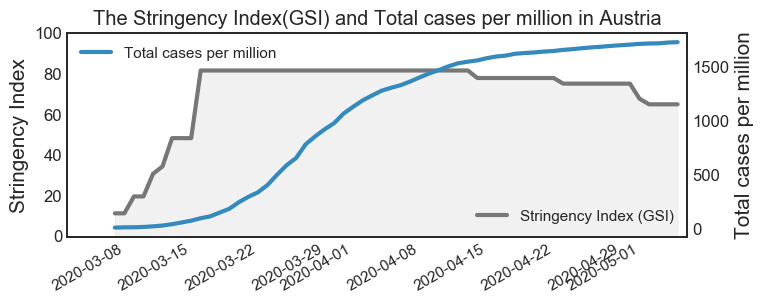

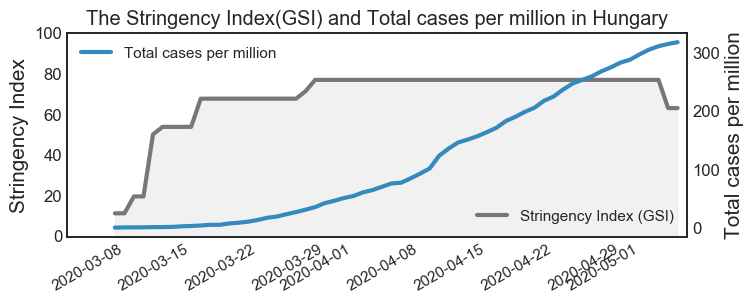

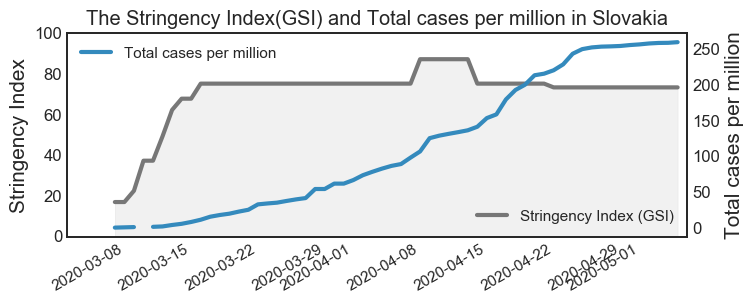

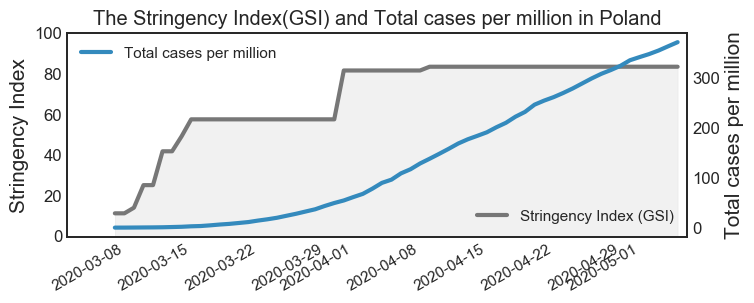

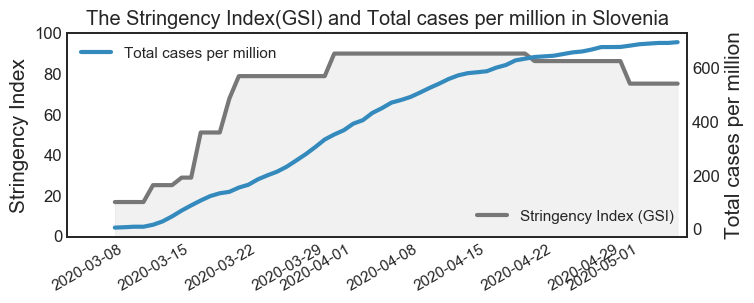

In [81]:

start = '3/7/2020'
end = '5/6/2020'

country_name_list=['Austria', 'Hungary','Slovakia', 'Poland','Slovenia']
simulation_start = datetime.datetime(2020, 3, 7)
simulation_end = datetime.datetime(2020, 5, 6)
delta_each_day = datetime.timedelta(days= 1)
simualtion_dates = mpl.dates.drange(simulation_start, simulation_end, delta_each_day)

for cou in country_name_list:
    tems = temdf[temdf['location'] == cou]['date'].tolist().index(start)
    teme = temdf[temdf['location'] == cou]['date'].tolist().index(end)
    tem_data =temdf[temdf['location'] == cou][tems:teme]
    fig=plt.figure(figsize=(8,3))
    ax = fig.add_subplot(111)
    ax_poli = ax.twinx()

    ax.plot_date(simualtion_dates, 
                          tem_data['stringency_index'].tolist(), label = 'Stringency Index (GSI)',
                          linestyle = "-", marker = "", color = 'C3',lw = 3)
    ax.fill_between(simualtion_dates, tem_data['stringency_index'].tolist(),color = 'C3',alpha =0.1)
    ax_poli.plot_date(simualtion_dates, 
                          tem_data['total_cases_per_million'].tolist(), label = 'Total cases per million',
                          linestyle = "-", marker = "", color = 'C1', lw = 3)

    ax.set_ylim(-0.5,100)
    ax.set_xlim(min(simualtion_dates)-5, max(simualtion_dates)+1)


    ax.tick_params(axis='y', labelsize= 12)
    ax_poli.tick_params(axis='y', labelsize= 12)
    ax_poli.legend(loc = 'upper left',prop={'size':11})
    ax.legend(loc = 'lower right',prop={'size' :11})

    ax.set_ylabel('Stringency Index',  fontsize = 15)
    ax_poli.set_ylabel('Total cases per million', fontsize = 15)
    ax.set_title(r'The Stringency Index(GSI) and Total cases per million in {}'.format(cou))
    
    plt.setp(ax.get_xticklabels(), fontsize=11)

    plt.setp(ax.get_xticklabels(), fontsize=11)
    fig.autofmt_xdate()
    plt.show()

#  Simulatie the pandenic of countries in the first 60 days. All modified SEIR models using in the following simulaiton are shown in the function section.

In [42]:
plt.rcParams.update(plt.rcParamsDefault)

In [43]:
plt.style.use('seaborn-white')

In [83]:
## number of run
tst = 500
## time of each run
tim  = 60
beta = 0.019

Aus_social_dis = SEIR_social_case_multi_run(G_Aus, Aus_stable_edges_list, Aus_long_dis_edges_list, 0.0010,
                                  0.8148,'Austria', tst , tim)

Slo_social_dis = SEIR_social_case_multi_run(G_Slo, Slo_stable_edges_list, Slo_long_dis_edges_list, 0.0014,
                                            0.8981,'Slovenia', tst , tim)

poland_social_dis = SEIR_social_case_multi_run(G_Poland, Poland_stable_edges_list, Poland_long_dis_edges_list, 0.0005,
                                  0.8333,'Poland', tst , tim)

Hun_social_dis = SEIR_social_case_multi_run(G_Hun, Hun_stable_edges_list, Hun_long_dis_edges_list, 0.0003,
                                            0.7685,'Hungary', tst , tim)

Slovakia_social_dis = SEIR_social_case_multi_run(G_Slovakia, Slovakia_stable_edges_list, Slovakia_long_dis_edges_list, 0.0002,
                                            0.7500,'Slovakia', tst , tim)

The cumulative case:  (63.244, 565.808, 23.787)
The cumulative case:  (45.046, 168.116, 12.966)
The cumulative case:  (24.328, 126.82, 11.261)
The cumulative case:  (18.606, 132.023, 11.49)
The cumulative case:  (18.91, 224.046, 14.968)


# save the data

In [85]:
# compare_social_dis = [Aus_social_dis,Hun_social_dis,Slo_social_dis,
#                       Slovakia_social_dis, poland_social_dis]
# country_name_list = ['Austria', 'Hungary','Slovenia','Slovakia', 'Poland']
# for i in range(5):
#     np.save('500{}_60_new.npy'.format(country_name_list[i]),compare_social_dis[i] )

# Visualization of results

# load the result data and generate the figure for the results

In [86]:
date_start = datetime.datetime(2019, 12, 31)
simulation_start = datetime.datetime(2020, 3, 1)
simulation_end = datetime.datetime(2020, 4, 30)
delta_each_day = datetime.timedelta(days= 6)
simualtion_dates_2 = mpl.dates.drange(simulation_start, simulation_end, delta_each_day)
simualtion_dates_3 = mpl.dates.drange(datetime.datetime(2020, 3, 1), datetime.datetime(2020, 4, 30), datetime.timedelta(days= 3))
simualtion_dates_4 = mpl.dates.drange(datetime.datetime(2020, 3, 1), datetime.datetime(2020, 5, 7), datetime.timedelta(days= 10))
print(len(simualtion_dates_2))
print(len(simualtion_dates_4))
print(len(simualtion_dates_3))

10
7
20


In [87]:
plt.style.use('seaborn-white')

In [88]:
### plot the result

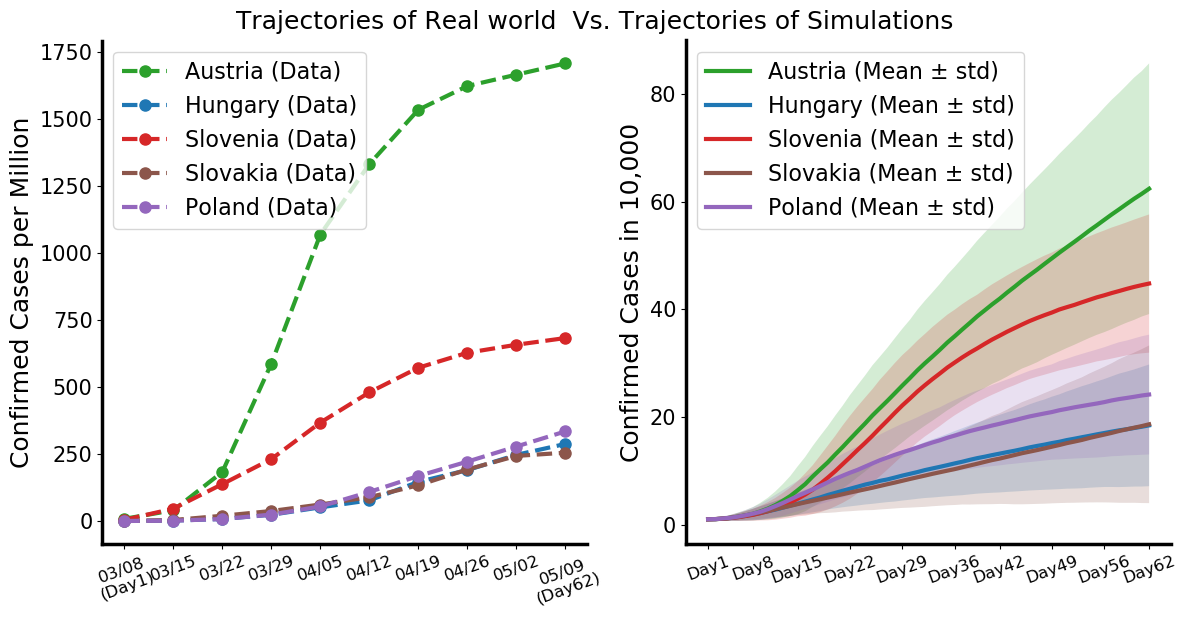

In [92]:
## conclusion of the social_distancing
##  mean and std
cmap = plt.get_cmap('tab10')
fig=plt.figure(figsize=(12,6))
ax_cumu = fig.add_subplot(121)
ax_poli = fig.add_subplot(122)
color_camp = [2,0,3,5,4,1]
compare_social_dis = [ Aus_social_dis,Hun_social_dis,Slo_social_dis,
                      Slovakia_social_dis, poland_social_dis]
country_name_list = ['Austria', 'Hungary','Slovenia','Slovakia', 'Poland']
country_name_list_print = ['Austria', 'Hungary','Slovenia','Slovakia', 'Poland']
for num in range(5):
    start = '3/7/2020'
    end = '5/6/2020'
    tems = temdf[temdf['location'] == country_name_list[num]]['date'].tolist().index(start)
    teme = temdf[temdf['location'] == country_name_list[num]]['date'].tolist().index(end)
    #em_data = real_track_6[real_track_6['location'] ==country_name_list[num]]
    ax_cumu.plot_date(simualtion_dates_2, 
                      [temdf[temdf['location'] == country_name_list[num]]['total_cases_per_million'].tolist()[tems:teme][i] for i in [k for k in  np.arange(0, 60, 6)]], 
                      label = country_name_list_print[num]+' (Data)',
                      linestyle = "--", marker='o',color= cmap(color_camp[num]),lw = 3,markersize=8)
    S_lowerbound  = [mean_var_std(compare_social_dis[num][1][i][1:])[0]-
                     mean_var_std(compare_social_dis[num][1][i][1:])[2] for i in range(len(compare_social_dis[num][1]))]
    S_upperbound  = [mean_var_std(compare_social_dis[num][1][i][1:])[0]+
                     mean_var_std(compare_social_dis[num][1][i][1:])[2] for i in range(len(compare_social_dis[num][1]))]

    ax_poli.plot_date(simualtion_dates,[np.mean(compare_social_dis[num][1][i][1:]) for i in [k for k in  np.arange(0,  300, 5)]], 
                 color = cmap(color_camp[num]),label = country_name_list_print[num]+' (Mean \u00B1 std)',linestyle = "-", marker = "",lw = 3)
    
    
    ax_poli.fill_between(simualtion_dates, [S_lowerbound[i] for i in [k for k in  np.arange(0,  300, 5)]],
                      [S_upperbound[i] for i in [k for k in  np.arange(0,300, 5)]], facecolor = cmap(color_camp[num]), alpha=0.2)

ax_cumu.set_ylabel('Confirmed Cases per Million', fontsize  = 18)
ax_poli.set_ylabel('Confirmed Cases in 10,000', fontsize  = 18)
ax_cumu.legend(prop={'size' :16})
ax_poli.legend(prop={'size' :16})


formatter = DateFormatter('%m/%d')
ax_cumu.xaxis.set_major_formatter(formatter)
ax_cumu.xaxis.set_tick_params(rotation=20, labelsize=12)
ax_poli.xaxis.set_tick_params(rotation=20, labelsize=12)

ax_cumu.set_xticks(simualtion_dates_2)
labels = ("03/08\n(Day1)", "03/15","03/22", "03/29", "04/05","04/12","04/19","04/26","05/02", "05/09\n(Day62)")
ax_cumu.set_xticklabels( labels)


ax_poli.set_xticks([simualtion_dates[i] for i in [0,6,12,19,26,33,39,46,53,59]])
labels = ("Day1", "Day8", "Day15","Day22", "Day29", "Day36","Day42", "Day49","Day56", "Day62")
ax_poli.set_xticklabels( labels)

ax_cumu.tick_params(axis='y', labelsize= 15)
ax_poli.tick_params(axis='y', labelsize= 15)


ax_cumu.spines['right'].set_visible(False)
ax_cumu.spines['top'].set_visible(False)
ax_poli.spines['right'].set_visible(False)
ax_poli.spines['top'].set_visible(False)

for axis in ['left','bottom']:
    ax_poli.spines[axis].set_linewidth(2.5)
    ax_cumu.spines[axis].set_linewidth(2.5)
    

plt.suptitle('Trajectories of Real world  Vs. Trajectories of Simulations',size = 18,y=1.02)
plt.tight_layout()    
plt.show()